In [1]:
import keras
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math, random, pickle, itertools,scipy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statistics import mean 
from IPython.display import display, HTML
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.datasets.samples_generator import make_blobs, make_moons
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import statsmodels.api as sm
from sklearn.svm import SVC
import random as rd
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
!aws s3 sync s3://ulcerclassification .

In [3]:
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [4]:
image_gen = image_gen.flow_from_directory(
    'Data',
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=651,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 651 images belonging to 4 classes.


In [5]:
image_gen.class_indices

{'go_to_er': 0, 'healthy_feet': 1, 'needs_TLC': 2, 'see_a_doctor': 3}

Second Try

Separate data into train and test

In [6]:
# split images and labels
images, labels = next(image_gen)
images.shape, labels.shape

((651, 224, 224, 3), (651, 4))

In [7]:
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.2, random_state=41)
X_model.shape, X_test.shape, y_model.shape, y_test.shape

((520, 224, 224, 3), (131, 224, 224, 3), (520, 4), (131, 4))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=41)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((416, 224, 224, 3), (104, 224, 224, 3), (416, 4), (104, 4))

In [25]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(224, 224,  3),
                      padding='SAME'))
# 64 bias parameters
# 64 * (3 * 3 * 3) weight parametrs
# Output is 64*224*224
cnn.add(layers.MaxPooling2D((2, 2)))
# Output is 64*112*112
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='SAME'))
# 32 bias parameters
# 32 * (3*3*64)
# Output is 32*112*112
cnn.add(layers.MaxPooling2D((2, 2)))
# Output is 32*56*56
cnn.add(layers.Flatten())
# Output is (100352,)
cnn.add(layers.Dense(32, activation='relu'))
# Output is (32,)
cnn.add(layers.Dense(4, activation='softmax'))
# Output is (1,)

cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc'])

In [26]:
saving_weights = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.2f}.hdf5',
    monitor='loss', verbose=0, save_best_only=False,
    save_weights_only=True, mode='auto', period=2
)

In [27]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [28]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [29]:
nan_problem = keras.callbacks.TerminateOnNaN()

In [30]:
csv_logger = keras.callbacks.CSVLogger('training.log')

In [31]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                3211296   
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [34]:
cnn.load_weights("weights.16-0.06.hdf5")

In [37]:
cnn1 = cnn.fit(X_train,
               y_train,
               epochs=10,
               batch_size=10,
               validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

Train on 416 samples, validate on 104 samples
Epoch 1/10
416/416 [==============================] - 38s 92ms/step - loss: 0.0353 - acc: 0.9928 - val_loss: 1.4395 - val_acc: 0.7188
Epoch 2/10
416/416 [==============================] - 38s 92ms/step - loss: 0.0376 - acc: 0.9934 - val_loss: 1.2150 - val_acc: 0.7476
Epoch 3/10
416/416 [==============================] - 39s 93ms/step - loss: 0.0376 - acc: 0.9904 - val_loss: 1.2901 - val_acc: 0.7284
Epoch 4/10
416/416 [==============================] - 40s 96ms/step - loss: 0.0345 - acc: 0.9922 - val_loss: 1.2437 - val_acc: 0.7308
Epoch 5/10
416/416 [==============================] - 39s 93ms/step - loss: 0.0329 - acc: 0.9940 - val_loss: 1.2706 - val_acc: 0.7260
Epoch 6/10
416/416 [==============================] - 38s 92ms/step - loss: 0.0305 - acc: 0.9934 - val_loss: 1.3370 - val_acc: 0.7284
Epoch 7/10
416/416 [==============================] - 38s 92ms/step - loss: 0.0293 - acc: 0.9928 - val_loss: 1.3290 - val_acc: 0.7524
Epoch 8/10
416/4

In [17]:
cnn.save('entire_model.hdf5')
cnn.save_weights('weights.hdf5')

In [15]:
num_classes = 4
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

Shape of each image in the training data:  (224, 224, 3)


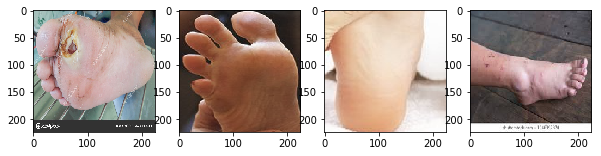

In [9]:
fig = plt.figure(figsize=(10, 10))

for i in range(1, 5):
    img = X_train[i-1]
    fig.add_subplot(2, 4, i)
    plt.imshow(img)

print('Shape of each image in the training data: ', X_train.shape[1:])

In [10]:
image_gen.class_indices

{'go_to_er': 0, 'healthy_feet': 1, 'needs_TLC': 2, 'see_a_doctor': 3}

In [11]:
#Importing the necessary libraries 

#Building up a Sequential model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu',input_shape = (300, 300, 3), padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 128)     

In [12]:
y_train.shape

(416, 4)

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [18]:
X_train_scratch = X_train/255.
X_test_scratch = X_test/255.
X_val_scratch =  X_val/255.


In [20]:
#Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5', 
                               verbose=1,save_best_only=True)

In [22]:
# Fitting the model on the train data and labels.
model.fit(X_train_scratch, y_train, batch_size=11, epochs=35, 
          verbose=1, callbacks=[checkpointer], validation_data= (X_val_scratch, y_val), shuffle=True)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

Preprocessing the images

In [57]:
data_te = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "Data",
    target_size=(224, 224),
    batch_size=4419,
    seed=123)

Found 651 images belonging to 4 classes.


In [58]:
data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'Data',
    target_size=(224, 224),
    batch_size=4419,
    seed=123)

Found 651 images belonging to 4 classes.


In [13]:
from keras.applications import inception_v3
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

In [16]:
imagenet = inception_v3.InceptionV3(weights='imagenet', include_top=False)
imagenet_new = imagenet.output
new_model = model
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dense(1024, activation='relu'))  # dense layer 2
new_model.add(Dense(512, activation='relu'))  # dense layer 3
# final layer with softmax activation
new_model.add(Dense(4, activation='softmax'))

ValueError: Input tensor must be of rank 3, 4 or 5 but was 2.

In [40]:
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 25,475,873
Trainable params: 25,441,441
Non-trainable params: 34,432
_____________________________________

In [ ]:
new_model.compile(optimizer='Adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
new_model.fit(X_train,
              y_train,
              epochs=20,
              batch_size=50,
              validation_data=(X_val, y_val))